In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lmfit
from scipy.optimize import curve_fit, root_scalar
from scipy.integrate import cumtrapz, trapz
plt.rcParams['figure.figsize'] = 15, 8
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
markerlist = ["d", "x", "o"]
#constants:
delta_a=1.92e-10
rho_l=1000
Rv=462
T=293.15
T_C = T -273.15
pv_sat = 611 * np.exp((17.08 * T_C)/(234.18 + T_C))

# Vapour Diffusion

In [2]:
def vap_fit(w,ld0,a,b):
    return a + (ld0 - a) * np.exp(-b * w) + 0 * w

In [3]:
vapour_diff = pd.read_excel("HS20_MBS_BPTA_201202_Exercise_Data.xls", sheet_name="vapour diff", header=13, nrows=3)

In [4]:
vapour_diff["Kv"] = (delta_a * vapour_diff["RH"] * pv_sat)/(vapour_diff["mu"] * rho_l * Rv * T)
vapour_diff["Dv"] = vapour_diff["Kv"] / vapour_diff["cap"]
vapour_diff["LDv"] = np.log10(vapour_diff["Dv"],)
vapour_diff

,RH,mu,Kv,pc,log pc,w1,w2,w,dwdpc1,dwdpc2,cap,Dv,LDv,fit LDv,Unnamed: 14,plot w,fit LDv.1
0,0.30,23,4.331768e-17,1.630604e+08,8.212349,2.156635,4.711406,6.868041,-1.123541e-08,-1.733502e-08,2.857043e-08,1.516172e-09,-8.819252,NaN,NaN,0,NaN
1,0.70,12,1.937263e-16,4.830638e+07,7.684004,6.051529,9.774440,15.825969,-1.058855e-07,-1.213490e-07,2.272345e-07,8.525390e-10,-9.069286,NaN,NaN,2,NaN
2,0.92,3,1.018447e-15,1.129281e+07,7.052802,20.118663,23.340691,43.459354,-1.398258e-06,-1.234226e-06,2.632484e-06,3.868767e-10,-9.412427,NaN,NaN,4,NaN


Parameters:
ld0: -8.540377098144795
a: -9.537522544757138
b: 0.047764688424495466


/home/strebdom/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


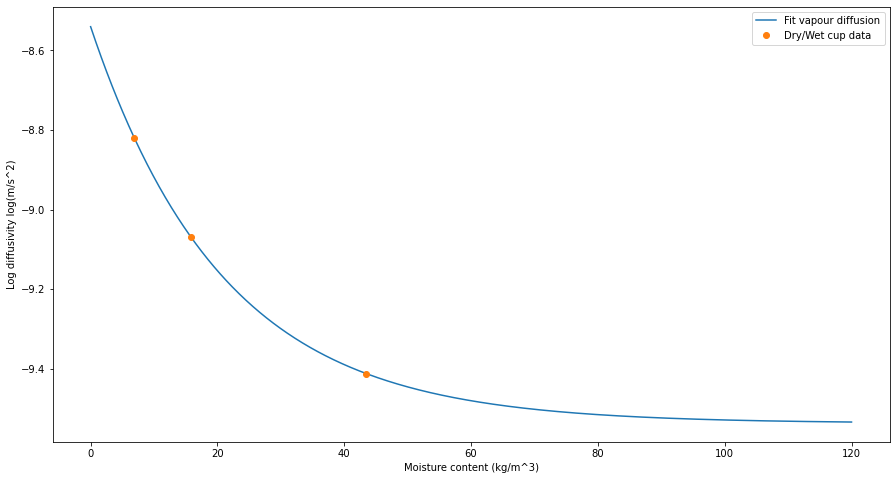

In [5]:
popt, pcov = curve_fit(vap_fit, vapour_diff["w"], vapour_diff["LDv"])
x = np.linspace(0,120,1000)
plt.plot(x, vap_fit(x, *popt), label="Fit vapour diffusion")
plt.plot(vapour_diff["w"], vapour_diff["LDv"], "o", label="Dry/Wet cup data")
plt.ylabel("Log diffusivity log(m/s^2)")
plt.xlabel("Moisture content (kg/m^3)")
plt.legend()
print("Parameters:\nld0: {}\na: {}\nb: {}".format(*popt))

# Liquid diffusivity

In [6]:
def f(F):
    return (F**2)/(2*F-1-(F-1+(3/2-4/np.pi)*F**2)*np.exp(-F))

def LD_wcap(F,A_cap, w_cap):
    return np.log10(f(F) * (A_cap/w_cap) ** 2 )



def fit_liquid_diff(pars, w, data=None, eps=None):
    parvals = pars.valuesdict()
    w_cap, A_cap, F = parvals["w_cap"], parvals["A_cap"], parvals["F"]
    model = LD_wcap(F,A_cap,w_cap) + (F/np.log(10)) * ((w-w_cap)/w_cap)
    if data is None:
        return model
    if eps is None:
        return (model - data)**2
    return (model-data)**2 / eps


liquid_diff = pd.read_excel("HS20_MBS_BPTA_201202_Exercise_Data.xls", sheet_name="liquid diff", header=7)

In [7]:
liquid_diff["dw/dlambda"][1:] = np.diff(liquid_diff["w"])/np.diff(liquid_diff["lambda"])
liquid_diff["int"][1:] = cumtrapz(liquid_diff["lambda"], liquid_diff["w"], axis=0)
liquid_diff["Dl"] = -0.5 * liquid_diff["int"] / liquid_diff["dw/dlambda"]
liquid_diff["LDl"] = np.log10(liquid_diff["Dl"])
A_cap = np.trapz(liquid_diff["lambda"], liquid_diff["w"])
w_cap = liquid_diff["w"].max()
liquid_diff

,lambda,w,dw/dlambda,dint,int,Dl,LDl,fit LDI,Unnamed: 8
0,0.000130,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000129,15.630013,-1.510321e+07,NaN,0.002024,6.699946e-11,-10.173929,NaN,NaN
2,0.000128,18.757759,-2.680067e+06,NaN,0.002425,4.524811e-10,-9.344400,NaN,NaN
3,0.000127,21.833037,-2.653420e+06,NaN,0.002817,5.307475e-10,-9.275112,NaN,NaN
4,0.000126,33.146019,-4.371773e+07,NaN,0.004248,4.858205e-11,-10.313524,NaN,NaN
...,...,...,...,...,...,...,...,...,...
84,0.000008,237.515052,-1.775234e+05,NaN,0.024068,6.778827e-08,-7.168845,NaN,NaN
85,0.000006,237.886289,-1.775235e+05,NaN,0.024071,6.779590e-08,-7.168797,NaN,NaN
86,0.000004,238.257526,-1.775207e+05,NaN,0.024073,6.780243e-08,-7.168755,NaN,NaN
87,0.000002,238.628763,-1.775225e+05,NaN,0.024074,6.780502e-08,-7.168738,NaN,NaN


Text(0, 0.5, 'Log liquid diffusivity [m²/s]')

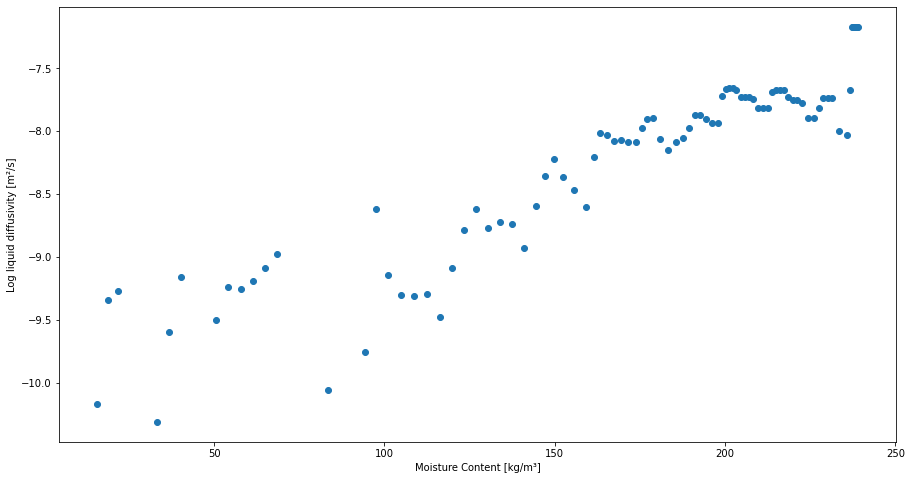

In [8]:
plt.plot(liquid_diff["w"], liquid_diff["LDl"], "o")
plt.xlabel("Moisture Content [kg/m³]")
plt.ylabel("Log liquid diffusivity [m²/s]")

In [9]:
p = lmfit.Parameters()

# add with tuples: (NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP)
p.add_many(('w_cap', w_cap, False, None,  None, None, None),
           ('A_cap', A_cap, False, None, None, None, None), 
           ('F', 10, True, 5, 15, None, None),
           ('F_F', None, False, None, None, '(F**2)/(2*F-1-(F-1+((3/2)-(4/pi))*F**2)*exp(-F))', None),
           ('LD_wcap', -1, False, None, None, 'log10(F_F * (A_cap/w_cap) ** 2)', None))
           

In [10]:
minner = lmfit.Minimizer(fit_liquid_diff, p, fcn_args=(liquid_diff["w"][1:], liquid_diff["LDl"][1:]))

In [11]:
fit = minner.minimize()
print(lmfit.fit_report(fit))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 88
    # variables        = 1
    chi-square         = 1.73394789
    reduced chi-square = 0.01993044
    Akaike info crit   = -343.570367
    Bayesian info crit = -341.093030
[[Variables]]
    w_cap:    239 (fixed)
    A_cap:    0.02407422 (fixed)
    F:        6.23918987 +/- 0.13381832 (2.14%) (init = 10)
    F_F:      3.39950467 +/- 0.06557687 (1.93%) == '(F**2)/(2*F-1-(F-1+((3/2)-(4/pi))*F**2)*exp(-F))'
    LD_wcap: -7.46227581 +/- 0.00000000 (0.00%) == 'log10(F_F * (A_cap/w_cap) ** 2)'


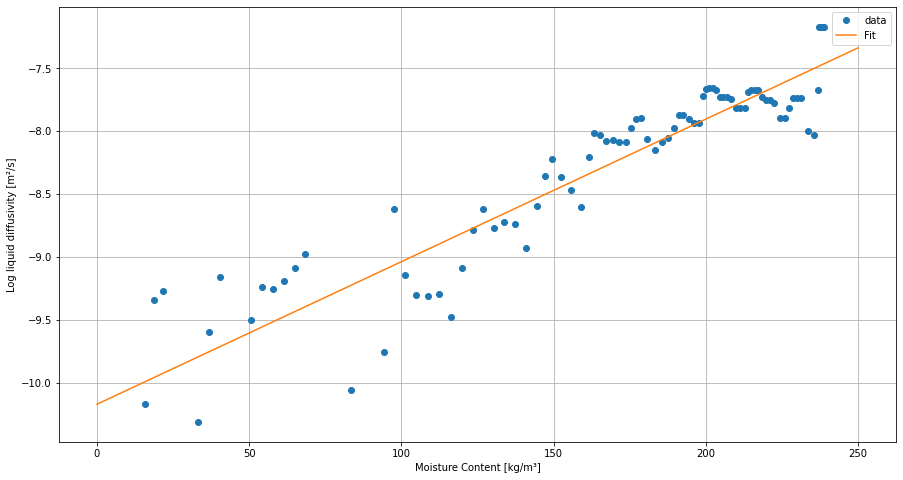

In [12]:
x = np.linspace(0,250,2500)
plt.plot(liquid_diff["w"], liquid_diff["LDl"], "o", label="data")
plt.xlabel("Moisture Content [kg/m³]")
plt.ylabel("Log liquid diffusivity [m²/s]")
plt.plot(x, fit_liquid_diff(fit.params,x), label="Fit")
plt.grid()
plt.legend()

# Moisture Diffusivity

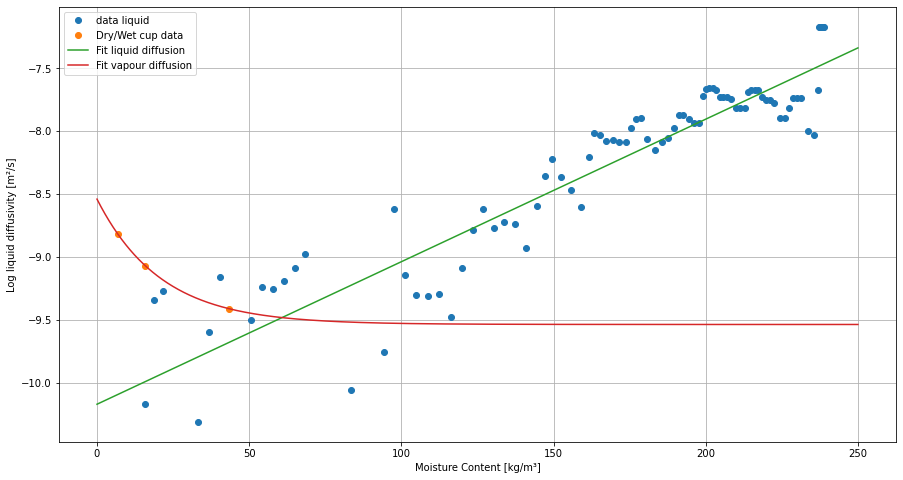

In [13]:
x = np.linspace(0,250,2500)
plt.plot(liquid_diff["w"], liquid_diff["LDl"], "o", label="data liquid")
plt.plot(vapour_diff["w"], vapour_diff["LDv"], "o", label="Dry/Wet cup data")
plt.xlabel("Moisture Content [kg/m³]")
plt.ylabel("Log liquid diffusivity [m²/s]")
plt.plot(x, fit_liquid_diff(fit.params,x), label="Fit liquid diffusion")
plt.plot(x, vap_fit(x, *popt), label="Fit vapour diffusion")
plt.grid()
plt.legend()

In [14]:
def root_fits_fun(x):
    return vap_fit(x, *popt) - fit_liquid_diff(fit.params, x)
root_fit = root_scalar(root_fits_fun,bracket=[0,150])
root_fit

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 60.78030676033718

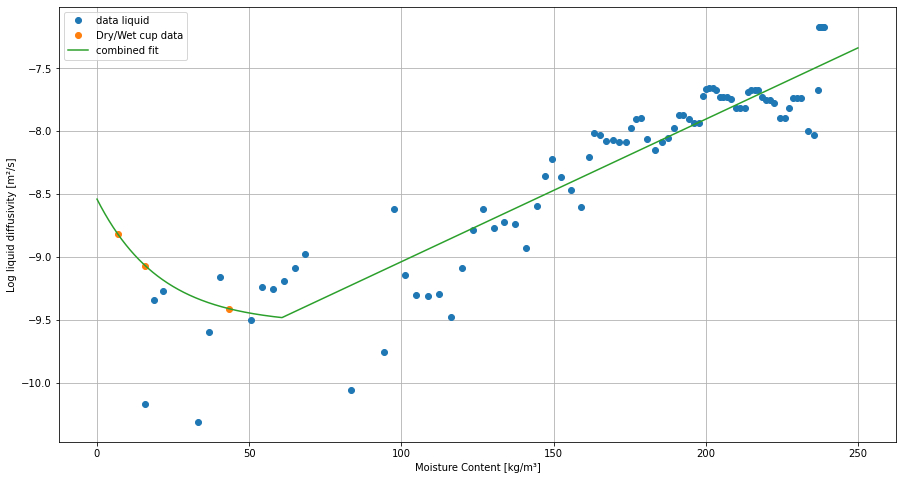

In [15]:
x = np.linspace(0,250,2500)
plt.plot(liquid_diff["w"], liquid_diff["LDl"], "o", label="data liquid")
plt.plot(vapour_diff["w"], vapour_diff["LDv"], "o", label="Dry/Wet cup data")
plt.xlabel("Moisture Content [kg/m³]")
plt.ylabel("Log liquid diffusivity [m²/s]")
y = np.where(x < root_fit.root, vap_fit(x, *popt), fit_liquid_diff(fit.params,x))
plt.plot(x,y, label="combined fit")
plt.grid()
plt.legend()

# Moisture Permeability

Parameters Vapour :
ld0: -8.540377098144795
a: -9.537522544757138
b: 0.047764688424495466
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 88
    # variables        = 1
    chi-square         = 1.73394789
    reduced chi-square = 0.01993044
    Akaike info crit   = -343.570367
    Bayesian info crit = -341.093030
[[Variables]]
    w_cap:    239 (fixed)
    A_cap:    0.02407422 (fixed)
    F:        6.23918987 +/- 0.13381832 (2.14%) (init = 10)
    F_F:      3.39950467 +/- 0.06557687 (1.93%) == '(F**2)/(2*F-1-(F-1+((3/2)-(4/pi))*F**2)*exp(-F))'
    LD_wcap: -7.46227581 +/- 0.00000000 (0.00%) == 'log10(F_F * (A_cap/w_cap) ** 2)'


Text(0, 0.5, 'log(moisture permeability) log[s]')

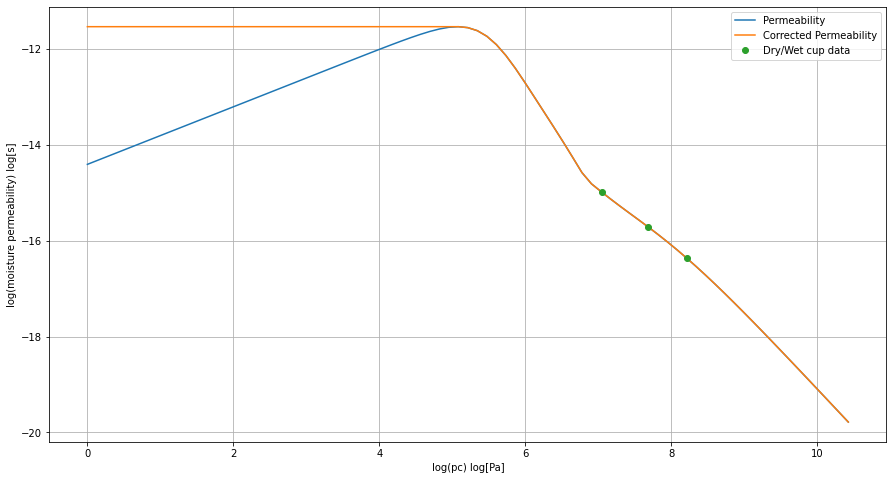

In [16]:
print("Parameters Vapour :\nld0: {}\na: {}\nb: {}".format(*popt))
print(lmfit.fit_report(fit))
ld0, a, b, c = popt[0], popt[1], popt[2], 0
liquid_params = fit.params.valuesdict()
w_cap, A_cap, F, F_F, LDwcap = liquid_params["w_cap"], liquid_params["A_cap"], liquid_params["F"], liquid_params["F_F"],liquid_params["LD_wcap"] 

moisture_perm = pd.read_excel("HS20_MBS_BPTA_201202_Exercise_Data.xls", sheet_name="moisture perm", header=8)
moisture_perm["LDv"] = vap_fit(moisture_perm["w"],ld0,a,b)
moisture_perm["LDl"] = fit_liquid_diff(fit.params, moisture_perm["w"])
moisture_perm["LD"] = np.where(moisture_perm.w < root_fit.root, vap_fit(moisture_perm.w, *popt), fit_liquid_diff(fit.params,moisture_perm.w))
moisture_perm["dwdpc"] = np.abs(moisture_perm["dwdpc1"] + moisture_perm["dwdpc2"])
moisture_perm["L K"] = np.log10(10**moisture_perm["LD"] * moisture_perm["dwdpc"])
log_k_idx_max = moisture_perm["L K"].idxmax()
moisture_perm["L Kcor"][0:log_k_idx_max] = moisture_perm["L K"].max()
moisture_perm["L Kcor"][log_k_idx_max:] = moisture_perm["L K"][log_k_idx_max:]
vapour_diff["dwdpc"] = np.abs(vapour_diff.dwdpc1 + vapour_diff.dwdpc2)
vapour_diff["L K"] = np.log10(10**vapour_diff["LDv"] * vapour_diff["dwdpc"])
plt.plot(moisture_perm["log pc"], moisture_perm["L K"], label="Permeability")
plt.plot(moisture_perm["log pc"], moisture_perm["L Kcor"], label="Corrected Permeability")
plt.plot(vapour_diff["log pc"], vapour_diff["L K"], "o", label="Dry/Wet cup data")
plt.grid()
plt.legend()
plt.xlabel("log(pc) log[Pa]")
plt.ylabel("log(moisture permeability) log[s]")